In [1]:
#imports

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from prepare import zillow_pipeline
import matplotlib.ticker as mtick

from sklearn.feature_selection import SelectKBest, f_regression, RFE

In [2]:
df = zillow_pipeline()

In [3]:
df.head()

,bedrooms,bathrooms,area,value,year,county,state
0,4,3.5,3100,1023282,1998,Orange,CA
1,2,1.0,1465,464000,1967,Ventura,CA
2,3,2.0,1243,564778,1962,Orange,CA
3,4,3.0,2376,145143,1970,Los Angeles,CA
4,4,3.0,2962,773303,1950,Los Angeles,CA


In [4]:
df.shape

(52246, 7)

In [5]:
df.isna().sum()

bedrooms     0
bathrooms    0
area         0
value        0
year         0
county       0
state        0
dtype: int64

<div class="alert alert-block alert-info">

Create bins for visuals

In [6]:
# Create a new column 'bedrooms_bins' with custom binning
df['bedrooms_bins'] = df['bedrooms'].apply(lambda x: 9 if x > 9 else x)

df['bathrooms_bins'] = df['bathrooms'].apply(lambda x: 6 if x > 6 else x)

# Create a new column 'area_bins' with custom binning
df['area_bins'] = df['area'].apply(lambda x: 6000 if x > 6001 else x)

df['value_bins'] = np.where(df['value'] > 3000000, 3000001, df['value'])

In [7]:
df.head()

,bedrooms,bathrooms,area,value,year,county,state,bedrooms_bins,bathrooms_bins,area_bins,value_bins
0,4,3.5,3100,1023282,1998,Orange,CA,4,3.5,3100,1023282
1,2,1.0,1465,464000,1967,Ventura,CA,2,1.0,1465,464000
2,3,2.0,1243,564778,1962,Orange,CA,3,2.0,1243,564778
3,4,3.0,2376,145143,1970,Los Angeles,CA,4,3.0,2376,145143
4,4,3.0,2962,773303,1950,Los Angeles,CA,4,3.0,2962,773303


In [8]:
df.bedrooms_bins.unique()

array([4, 2, 3, 6, 5, 1, 7, 8, 9])

In [9]:
df.columns

Index(['bedrooms', 'bathrooms', 'area', 'value', 'year', 'county', 'state',
       'bedrooms_bins', 'bathrooms_bins', 'area_bins', 'value_bins'],
      dtype='object')

In [10]:
cols = ['bedrooms', 'bathrooms', 'area', 'value', 'year']

for col in cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col} Min: {min_val}, Max: {max_val}")

bedrooms Min: 1, Max: 14
bathrooms Min: 1.0, Max: 18.0
area Min: 152, Max: 21929
value Min: 1000, Max: 49061236
year Min: 1878, Max: 2016


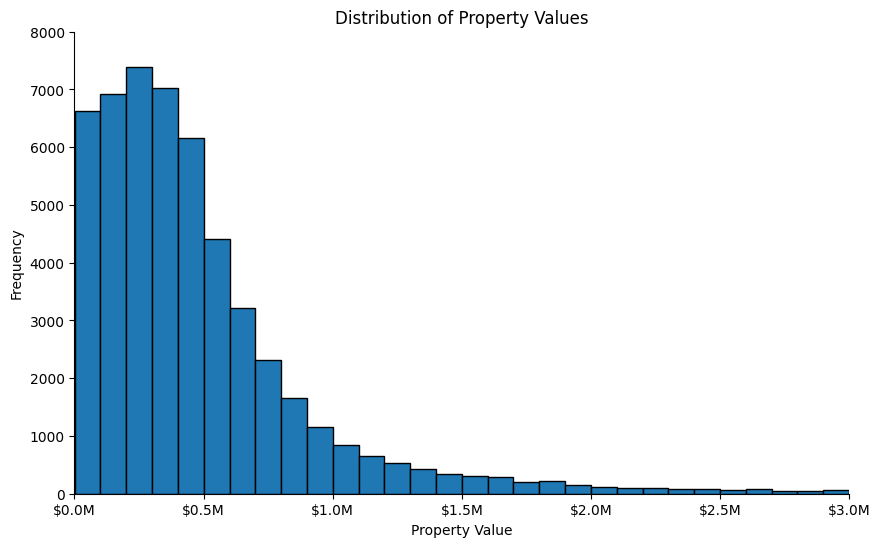

In [11]:
# Create a histogram of property values
plt.figure(figsize=(10, 6))
plt.hist(df['value'], bins=491, color='#1f77b4', edgecolor='black')
plt.xlabel('Property Value')
plt.ylabel('Frequency')
plt.title('Distribution of Property Values')
#plt.grid(True)

plt.xlim(0, 3000000)  # xlim for property size
plt.ylim(0, 8000)  # ylim for property value
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.1f}M'.format(x / 1e6)))  # Corrected the y-axis

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



# Format the y-axis labels to display in millions (M) or thousands (K)
# def format_y_axis_labels(x, _):
#     if x >= 1e6:
#         return '${:.0f}M'.format(x / 1e6)
#     elif x >= 1e3:
#         return '${:.1f}M'.format(x / 1e6)
#     else:
#         return '${:.0f}'.format(x)

# plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(format_y_axis_labels))


plt.show()

1. **Hypothesis 1: Property Size Impact**
   - *Question:* Does the size of a property impact its value?
   - *Null Hypothesis (H0):* There is no significant relationship between property size (square footage) and property value.
   - *Alternative Hypothesis (H1):* Property size (square footage) is significantly related to property value.


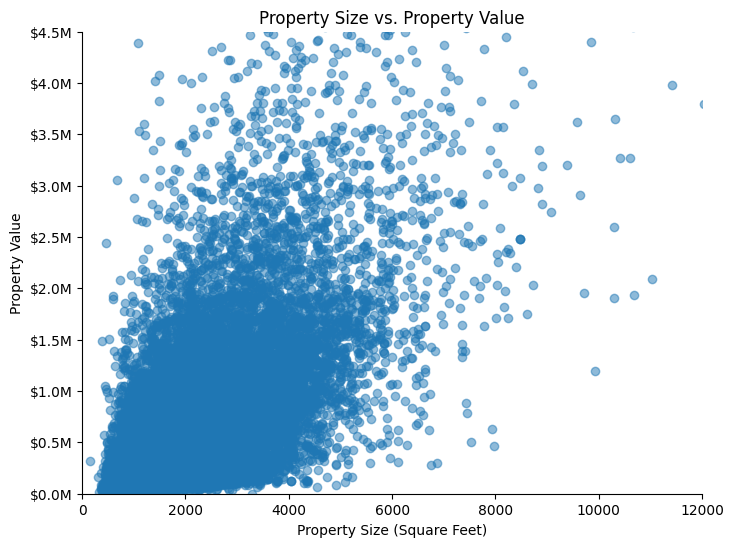

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df['area'], df['value'], alpha=0.5)
plt.xlabel('Property Size (Square Feet)')
plt.ylabel('Property Value')
plt.title('Property Size vs. Property Value')
plt.grid(False)

plt.xlim(0, 12000)  # xlim for property size
plt.ylim(0, 4500000)  # ylim for property value


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.1f}M'.format(x / 1e6)))  # Corrected the y-axis 
plt.show()


In [13]:
from scipy.stats import shapiro

# Hypothesis 1: Property Size Impact
# Test for Normality (Shapiro-Wilk):
stat, p = shapiro(df['area'])

if p < 0.05:
    print(f"Result for Property Size: Reject the null hypothesis (H0). Data is not normally distributed (p-value={p}).")
else:
    print(f"Result for Property Size: Fail to reject the null hypothesis (H0). Data is normally distributed (p-value={p}).")


Result for Property Size: Reject the null hypothesis (H0). Data is not normally distributed (p-value=0.0).


/usr/local/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
from scipy.stats import spearmanr

# Hypothesis 1: Property Size Impact
r, p = spearmanr(df['area'], df['value'])

if p < 0.05:
    print(f"Result for Property Size: There is a significant monotonic relationship between property size and value (p-value={p}).")
else:
    print(f"Result for Property Size: There is no significant monotonic relationship between property size and value (p-value={p}).")


Result for Property Size: There is a significant monotonic relationship between property size and value (p-value=0.0).


In [15]:
from scipy.stats import pearsonr

# Hypothesis Test
corr_coefficient, p_value = pearsonr(df['area'], df['value'])

if p_value < 0.05:
    print(f"Result: Reject the null hypothesis (H0). There is a significant relationship between property size and value (p-value={p_value}).")
else:
    print(f"Result: Fail to reject the null hypothesis (H0). There is no significant relationship between property size and value (p-value={p_value}).")


Result: Reject the null hypothesis (H0). There is a significant relationship between property size and value (p-value=0.0).



2. **Hypothesis 2: Property Age Influence**
   - *Question:* Does the age of a property, based on the year it was built, influence its value?
   - *Null Hypothesis (H0):* There is no significant relationship between the age of a property (year built) and property value.
   - *Alternative Hypothesis (H1):* The age of a property (year built) is significantly related to property value.


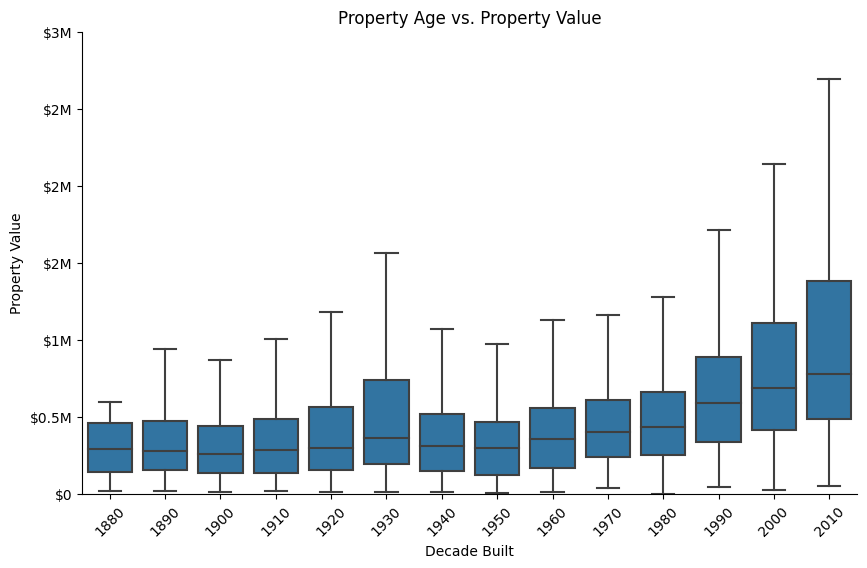

In [16]:
# Create a new column 'decade' by binning 'year' into decades
df['decade'] = (df['year'] // 10) * 10

plt.figure(figsize=(10, 6))
sns.boxplot(x='decade', y='value', data=df, showfliers = False, color= '#1f77b4')
plt.xlabel('Decade Built')
plt.ylabel('Property Value')
plt.title('Property Age vs. Property Value')
plt.xticks(rotation=45)
plt.grid(False)
plt.ylim(0, 3000000)  # ylim for property value
plt.xlim(0.5, 14.5)  # xlim for bedrooms

# Format the y-axis labels to display in millions (M) or thousands (K)
def format_y_axis_labels(x, _):
    if x >= 1e6:
        return '${:.0f}M'.format(x / 1e6)
    elif x >= 1e3:
        return '${:.1f}M'.format(x / 1e6)
    else:
        return '${:.0f}'.format(x)

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y_axis_labels))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


In [17]:
# Hypothesis 2: Property Age Influence
# Test for Normality (Shapiro-Wilk):
stat, p = shapiro(df['year'])

if p < 0.05:
    print(f"Result for Property Age: Reject the null hypothesis (H0). Data is not normally distributed (p-value={p}).")
else:
    print(f"Result for Property Age: Fail to reject the null hypothesis (H0). Data is normally distributed (p-value={p}).")


Result for Property Age: Reject the null hypothesis (H0). Data is not normally distributed (p-value=0.0).


/usr/local/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
# Hypothesis 2: Property Age Influence
r, p = spearmanr(df['year'], df['value'])

if p < 0.05:
    print(f"Result for Property Age: There is a significant monotonic relationship between property age and value (p-value={p}).")
else:
    print(f"Result for Property Age: There is no significant monotonic relationship between property age and value (p-value={p}).")


Result for Property Age: There is a significant monotonic relationship between property age and value (p-value=0.0).


In [19]:
from scipy.stats import f_oneway

# Hypothesis Test
years_built_groups = [df[df['year'] == year]['value'] for year in df['year'].unique()]
f_statistic, p_value = f_oneway(*years_built_groups)

if p_value < 0.05:
    print(f"Result: Reject the null hypothesis (H0). There is a significant relationship between property age and value (p-value={p_value}).")
else:
    print(f"Result: Fail to reject the null hypothesis (H0). There is no significant relationship between property age and value (p-value={p_value}).")


Result: Reject the null hypothesis (H0). There is a significant relationship between property age and value (p-value=0.0).



3. **Hypothesis 3: Bedroom and Bathroom Count**
   - *Question:* Do properties with a higher number of bedrooms and bathrooms tend to have higher values?
   - *Null Hypothesis (H0):* There is no significant relationship between the number of bedrooms or bathrooms and property value.
   - *Alternative Hypothesis (H1):* The number of bedrooms or bathrooms is significantly related to property value.


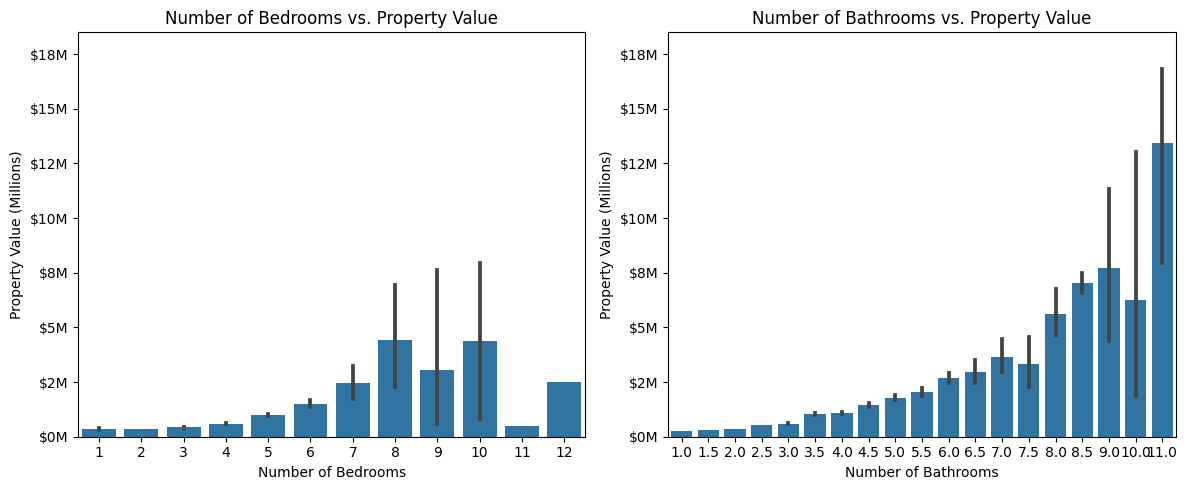

In [20]:
import matplotlib.ticker as mtick  # Import the mtick module

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for Bedrooms
sns.barplot(x='bedrooms', y='value', data=df, ax=axes[0], color='#1f77b4') 
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_ylabel('Property Value (Millions)')
axes[0].set_title('Number of Bedrooms vs. Property Value')
axes[0].set_ylim(-0.5, 18500000)  # xlim for bathrooms
axes[0].set_xlim(-0.5, 11.5)  # xlim for bedrooms
axes[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.0f}M'.format(x / 1e6)))

# Plot for Bathrooms
sns.barplot(x='bathrooms', y='value', data=df, ax=axes[1], color='#1f77b4') 
axes[1].set_xlabel('Number of Bathrooms')
axes[1].set_ylabel('Property Value (Millions)')
axes[1].set_title('Number of Bathrooms vs. Property Value')
axes[1].set_ylim(-0.5, 18500000)  # xlim for bathrooms
axes[1].set_xlim(-0.5, 18.5)  # xlim for bathrooms


axes[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.0f}M'.format(x / 1e6)))

plt.tight_layout()
plt.show()


In [21]:
# Hypothesis 3: Bedroom and Bathroom Count
stat_bedroom, p_bedroom = shapiro(df['bedrooms'])
stat_bathroom, p_bathroom = shapiro(df['bathrooms'])

if p_bedroom < 0.05:
    print(f"Result for Bedroom Count: Reject the null hypothesis (H0). Data is not normally distributed (p-value={p_bedroom}).")
else:
    print(f"Result for Bedroom Count: Fail to reject the null hypothesis (H0). Data is normally distributed (p-value={p_bedroom}).")

if p_bathroom < 0.05:
    print(f"Result for Bathroom Count: Reject the null hypothesis (H0). Data is not normally distributed (p-value={p_bathroom}).")
else:
    print(f"Result for Bathroom Count: Fail to reject the null hypothesis (H0). Data is normally distributed (p-value={p_bathroom}).")


Result for Bedroom Count: Reject the null hypothesis (H0). Data is not normally distributed (p-value=0.0).
Result for Bathroom Count: Reject the null hypothesis (H0). Data is not normally distributed (p-value=0.0).


/usr/local/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [22]:
# Hypothesis 3: Bedroom and Bathroom Count
r_bedroom, p_bedroom = spearmanr(df['bedrooms'], df['value'])
r_bathroom, p_bathroom = spearmanr(df['bathrooms'], df['value'])

if p_bedroom < 0.05:
    print(f"Result for Bedroom Count: There is a significant monotonic relationship between bedroom count and value (p-value={p_bedroom}).")
else:
    print(f"Result for Bedroom Count: There is no significant monotonic relationship between bedroom count and value (p-value={p_bedroom}).")

if p_bathroom < 0.05:
    print(f"Result for Bathroom Count: There is a significant monotonic relationship between bathroom count and value (p-value={p_bathroom}).")
else:
    print(f"Result for Bathroom Count: There is no significant monotonic relationship between bathroom count and value (p-value={p_bathroom}).")


Result for Bedroom Count: There is a significant monotonic relationship between bedroom count and value (p-value=0.0).
Result for Bathroom Count: There is a significant monotonic relationship between bathroom count and value (p-value=0.0).


In [23]:
# Hypothesis Test
bedroom_groups = [df[df['bedrooms'] == n]['value'] for n in df['bedrooms'].unique()]
f_statistic_bedroom, p_value_bedroom = f_oneway(*bedroom_groups)

bathroom_groups = [df[df['bathrooms'] == n]['value'] for n in df['bathrooms'].unique()]
f_statistic_bathroom, p_value_bathroom = f_oneway(*bathroom_groups)

if p_value_bedroom < 0.05 or p_value_bathroom < 0.05:
    print(f"Result: Reject the null hypothesis (H0). There is a significant relationship between bedroom/bathroom count and value (p-value_bedroom={p_value_bedroom}, p-value_bathroom={p_value_bathroom}).")
else:
    print(f"Result: Fail to reject the null hypothesis (H0). There is no significant relationship between bedroom/bathroom count and value (p-value_bedroom={p_value_bedroom}, p-value_bathroom={p_value_bathroom}).")


Result: Reject the null hypothesis (H0). There is a significant relationship between bedroom/bathroom count and value (p-value_bedroom=0.0, p-value_bathroom=0.0).



4. **Hypothesis 4: Location Matters**
   - *Question:* Does the location of a property impact its value?
   - *Null Hypothesis (H0):* There is no significant relationship between the location of a property (county or state) and property value.
   - *Alternative Hypothesis (H1):* The location of a property (county or state) is significantly related to property value.

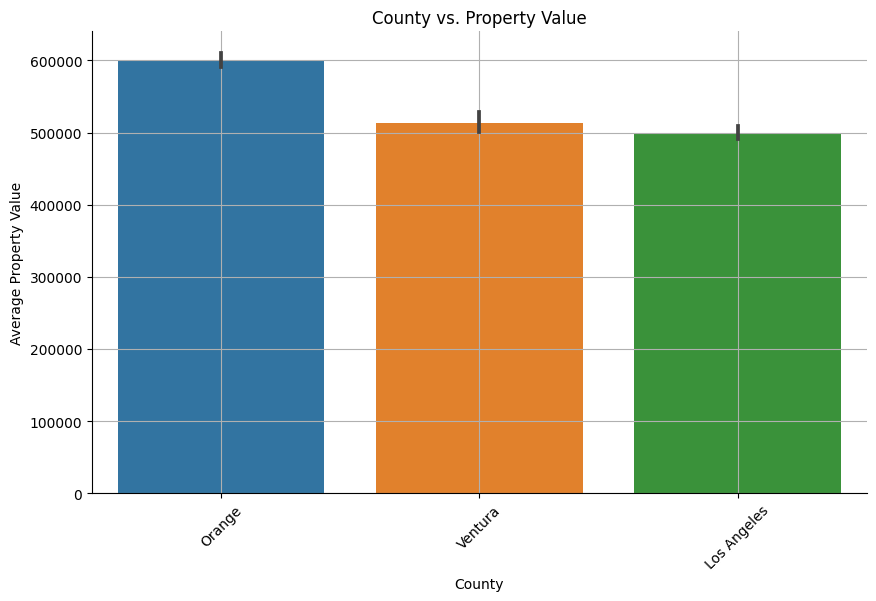

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='county', y='value', data=df)
plt.xlabel('County')
plt.ylabel('Average Property Value')
plt.title('County vs. Property Value')
plt.xticks(rotation=45)
plt.grid(True)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


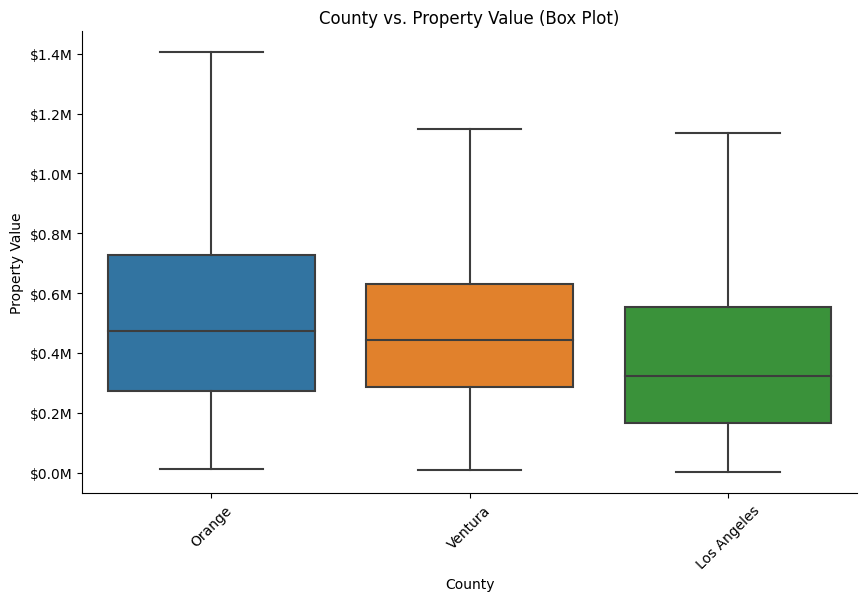

In [25]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='county', y='value', data=df, showfliers = False)  # Use sns.boxplot for box plot
plt.xlabel('County')
plt.ylabel('Property Value')
plt.title('County vs. Property Value (Box Plot)')
plt.xticks(rotation=45)
plt.grid(False)

# Format the y-axis tick labels as dollars with millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.1f}M'.format(x / 1e6)))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


In [26]:
# Hypothesis 4: Location Matters
# Assuming you have 'county' as a categorical variable and 'value' as the continuous variable
r, p = spearmanr(df['county'], df['value'])

if p < 0.05:
    print(f"Result for Location and Property Values: There is a significant monotonic relationship between location and value (p-value={p}).")
else:
    print(f"Result for Location and Property Values: There is no significant monotonic relationship between location and value (p-value={p}).")


Result for Location and Property Values: There is a significant monotonic relationship between location and value (p-value=0.0).


In [27]:
from scipy.stats import kruskal

# Hypothesis Test
county_groups = [df[df['county'] == county]['value'] for county in df['county'].unique()]
h_statistic, p_value_county = kruskal(*county_groups)

if p_value_county < 0.05:
    print(f"Result: Reject the null hypothesis (H0). There is a significant relationship between location and value (p-value={p_value_county}).")
else:
    print(f"Result: Fail to reject the null hypothesis (H0). There is no significant relationship between location and value (p-value={p_value_county}).")


Result: Reject the null hypothesis (H0). There is a significant relationship between location and value (p-value=0.0).


In [28]:
def bedr_vs_value_plt2(df):
    # Define a function to remove outliers based on IQR
    def remove_outliers(data, col):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    # Remove outliers from the DataFrame
    df = remove_outliers(df, 'value')

    plt.figure(figsize=(10, 6))

    sns.barplot(x='bedrooms', y='value', data=df, color='#1f77b4') 
    plt.xlabel('Number of Bedrooms')
    plt.ylabel('Property Value')
    plt.title('Number of Bedrooms vs. Property Value')
    plt.ylim(0, 10000000)  # ylim for property value
    plt.xlim(-0.5, 11.5)  # xlim for bedrooms
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.0f}M'.format(x / 1e6)))  # Corrected the y-axis formatter
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:
# bedr_vs_value_plt(your_dataframe)


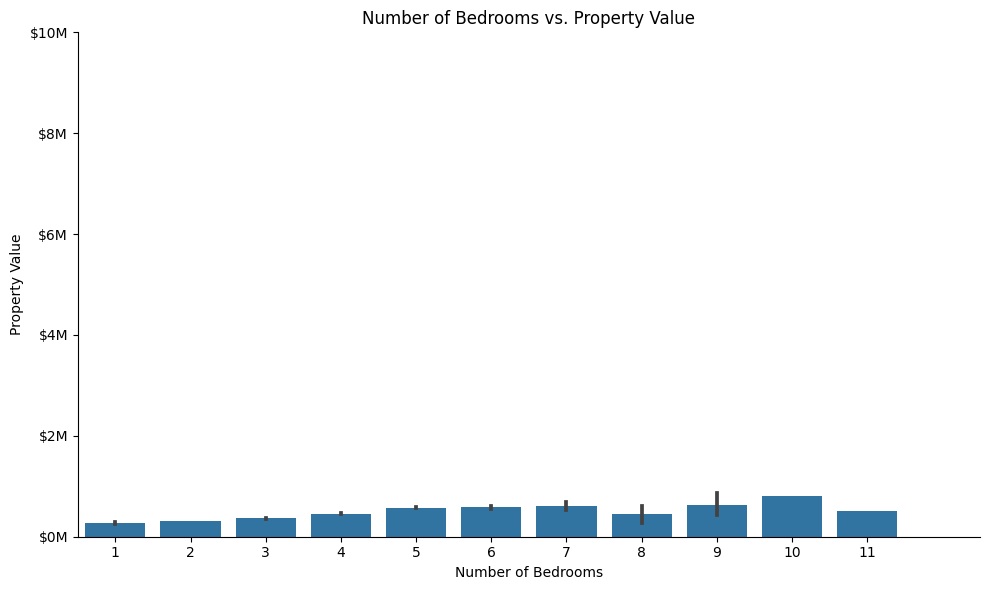

In [29]:
bedr_vs_value_plt2(df)

In [30]:
# create the index and column names of the dataframe which will save the correlation results
correlation_results = pd.DataFrame(index=train.columns, columns=train.columns)

#loop each variable agains every variable
for col1 in train.columns:
    for col2 in train.columns:
        # Compute the correlation between col1 and col2
        correlation = train[col1].corr(train[col2])
        
        # Store the correlation value in the results DataFrame
        correlation_results.loc[col1, col2] = correlation

# Convert the correlation matrix to a string with left-aligned values
correlation_str = correlation_results.applymap(lambda x: str(round(x, 4)).ljust(10))

# Print the entire correlation matrix with left-aligned values
with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
    print(correlation_str)


NameError: name 'train' is not defined

In [ ]:
df.head()

,bedrooms,bathrooms,area,value,year,county,state,bedrooms_bins,bathrooms_bins,area_bins,value_bins,decade
0,4,3.5,3100,1023282,1998,Orange,CA,4,3.5,3100,1023282,1990
1,2,1.0,1465,464000,1967,Ventura,CA,2,1.0,1465,464000,1960
2,3,2.0,1243,564778,1962,Orange,CA,3,2.0,1243,564778,1960
3,4,3.0,2376,145143,1970,Los Angeles,CA,4,3.0,2376,145143,1970
4,4,3.0,2962,773303,1950,Los Angeles,CA,4,3.0,2962,773303,1950


In [ ]:
X = df.drop(columns = ['value'])
y = df.value

In [ ]:
skb = SelectKBest(f_regression, k = 2)

skb.fit(X, y)

ValueError: could not convert string to float: 'Orange'

In [ ]:
skb_mask = skb.get_support()
X.columns[skb_mask]

Index(['total_bill', 'size'], dtype='object')

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def rfe_feature_selection(df, col_name, k):
    """
    Perform Recursive Feature Elimination (RFE) to select the top k features for a given target column.

    Parameters:
        df (DataFrame): The input DataFrame containing both features and the target column.
        col_name (str): The name of the target column to predict.
        k (int): The number of top features to select.

    Returns:
        selected_df (DataFrame): A DataFrame with two columns: 'Column Name' and 'Rank'.
            'Column Name' contains the column names of the selected features.
            'Rank' contains their corresponding ranks in terms of importance.
    
    This function performs RFE with a Linear Regression estimator to select the top k features
    based on their importance in predicting the target column. It iteratively selects the most
    important feature, removes it from consideration, and repeats the process until k features
    have been selected.

    Note:
    - The function filters the input DataFrame to keep only numeric and float columns for feature selection.

    Example Usage:
    selected_features_df = rfe_feature_selection(df, 'target_col', 5)
    print(selected_features_df)
    """
    # Filter X to keep only numeric and float columns
    X = df.select_dtypes(include=['number', 'float']).drop(columns=[col_name])
    X = X.drop
    y = df[col_name]

    # Initialize an empty DataFrame for selected features
    selected_df = pd.DataFrame(columns=['Column Name', 'Rank'])

    for rank in range(1, k + 1):
        # Initialize the RFE model with a linear regression estimator
        estimator = LinearRegression()
        rfe = RFE(estimator, n_features_to_select=1)
        rfe.fit(X, y)

        # Find the index of the selected feature
        selected_feature_idx = rfe.support_.argmax()
        rfe_mask = selector.support_

        # Get the name of the selected feature and add it to the selected_df
        selected_feature_name = X.columns[selected_feature_idx]
        new_column_name = X.columns[rfe_mask][-1]
        
        selected_df = selected_df.append({'Column Name': selected_feature_name, 'Rank': rank}, ignore_index=True)
        selected_columns.append(new_column_name)

        # Remove the selected feature from the feature set
        X = X.drop(columns=[selected_feature_name])
        X = X.drop(columns=[new_column_name])
        
    # Create a DataFrame with selected column names and their ranks
    selected_df = pd.DataFrame({
        'Column Name': selected_columns,
        'Rank': range(1, k + 1)
    })

    return selected_df

    for i in range(1, k + 1):
        # Initialize the RFE selector with a linear regression model
        selector = RFE(LinearRegression(), n_features_to_select=i)
        
        # Fit RFE on X and y
        selector.fit(X, y)
        
        # Get the mask of selected features
        rfe_mask = selector.support_
        
        # Get the column name of the newly selected feature
        new_column_name = X.columns[rfe_mask][-1]
        
        # Append the new column name to the list of selected columns
        selected_columns.append(new_column_name)
        
        # Remove the selected column from X for the next iteration
        X = X.drop(columns=[new_column_name])
    
    # Create a DataFrame with selected column names and their ranks
    selected_df = pd.DataFrame({
        'Column Name': selected_columns,
        'Rank': range(1, k + 1)
    })


In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def rfe_feature_selection(df, col_name, k=2):
    """
    Performs Recursive Feature Elimination (RFE) to select the top k features for regression from a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing features and the target column.
        col_name (str): The name of the target column.
        k (int): The number of top features to select (default is 2).

    Returns:
        selected_df (DataFrame): A DataFrame with two columns: 'Column Name' and 'Rank'.
            'Column Name' contains the column names of the selected features.
            'Rank' contains their corresponding ranks in terms of importance.

    Example:
        selected_features = rfe_feature_selection(your_dataframe, 'value', k=2)
    """
    # Create X and y
    X = df.drop(columns=[col_name])  # Remove the target column
    y = df[col_name]
    
    # Filter X to keep only numeric and float columns
    X = X.select_dtypes(include=['number', 'float'])
    
    selected_columns = []  # To store the selected columns
    
    for i in range(1, k + 1):
        # Initialize the RFE selector with a linear regression model
        selector = RFE(LinearRegression(), n_features_to_select=i)
        
        # Fit RFE on X and y
        selector.fit(X, y)
        
        # Get the mask of selected features
        rfe_mask = selector.support_
        
        # Get the column name of the newly selected feature
        new_column_name = X.columns[rfe_mask][-1]
        
        # Append the new column name to the list of selected columns
        selected_columns.append(new_column_name)
        
        # Remove the selected column from X for the next iteration
        X = X.drop(columns=[new_column_name])
    
    # Create a DataFrame with selected column names and their ranks
    selected_df = pd.DataFrame({
        'Column Name': selected_columns,
        'Rank': range(1, k + 1)
    })
    
    return selected_df


In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def rfe_feature_selection(df, col_name, k=2):
    """
    Performs Recursive Feature Elimination (RFE) to select the top k features for regression from a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing features and the target column.
        col_name (str): The name of the target column.
        k (int): The number of top features to select (default is 2).

    Returns:
        selected_df (DataFrame): A DataFrame with two columns: 'Column Name' and 'Rank'.
            'Column Name' contains the column names of the selected features.
            'Rank' contains their corresponding ranks in terms of importance.

    Example:
        selected_features = rfe_feature_selection(your_dataframe, 'value', k=2)
    """
    # Create X and y
    X = df.drop(columns=[col_name])  # Remove the target column
    y = df[col_name]
    
    # Filter X to keep only numeric and float columns
    X = X.select_dtypes(include=['number', 'float'])
    
    selected_columns = []  # To store the selected columns
    
    for i in range(1, k + 1):
        # Initialize the RFE selector with a linear regression model
        selector = RFE(LinearRegression(), n_features_to_select=i)
        
        # Fit RFE on X and y
        selector.fit(X, y)
        
        # Get the mask of selected features
        rfe_mask = selector.support_
        
        # Get the column name of the newly selected feature
        new_column_name = X.columns[rfe_mask][-1]
        
        # Append the new column name to the list of selected columns
        selected_columns.append(new_column_name)
        
        # Remove the selected column from X for the next iteration
        X = X.drop(columns=[new_column_name])
    
    # Create a DataFrame with selected column names and their ranks
    selected_df = pd.DataFrame({
        'Column Name': selected_columns,
        'Rank': range(1, k + 1)
    })
    
    return selected_df


In [ ]:
rfe_feature_selection(df, 'value', 3)

,Column Name,Rank
0,bathrooms,1
1,year,2
2,area,3


In [ ]:
X = df.drop(columns = ['value', 'county', 'state'])
y = df.value

In [ ]:
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select=3)

rfe.fit(X, y)
rfe_mask = rfe.get_support()
X.columns[rfe_mask]

Index(['bedrooms', 'bathrooms', 'year'], dtype='object')

In [ ]:
import pandas as pd
from sklearn.linear_model import Lasso

def lasso_feature_selection(df, col_name, k=2):
    """
    Performs LASSO feature selection to select the top k features for regression from a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame containing features and the target column.
        col_name (str): The name of the target column.
        k (int): The number of top features to select (default is 2).

    Returns:
        selected_df (DataFrame): A DataFrame with two columns: 'Column Name' and 'Coefficient'.
            'Column Name' contains the column names of the selected features.
            'Coefficient' contains the corresponding LASSO regression coefficients.

    Example:
        selected_features = lasso_feature_selection(your_dataframe, 'value', k=2)
    """
    # Create X and y
    X = df.drop(columns=[col_name])  # Remove the target column
    y = df[col_name]
    
    # Filter X to keep only numeric and float columns
    X = X.select_dtypes(include=['number', 'float'])
    
    # Initialize LASSO regression with alpha=1.0 (adjust as needed)
    lasso = Lasso(alpha=1.0)
    
    # Fit LASSO on X and y
    lasso.fit(X, y)
    
    # Create a DataFrame with selected column names and their coefficients
    selected_df = pd.DataFrame({
        'Column Name': X.columns,
        'Coefficient': lasso.coef_
    })
    
    # Sort the DataFrame by absolute coefficient value in descending order
    selected_df['Coefficient'] = abs(selected_df['Coefficient'])
    selected_df = selected_df.sort_values(by='Coefficient', ascending=False)
    
    # Keep the top k features
    selected_df = selected_df.head(k)
    
    return selected_df


In [ ]:
lasso_feature_selection(df, 'value', 3)

,Column Name,Coefficient
0,bedrooms,143943.662773
1,bathrooms,121987.864275
3,year,4501.568974


In [ ]:
def rfe_ranking(data, target_col, k):
    """
    Perform Recursive Feature Elimination (RFE) using Linear Regression as the estimator
    and return column names and their RFE rankings.

    Parameters:
        - data: The input DataFrame containing all the features and the target variable.
        - target_col: The name of the target column (the column you want to predict).
        - k: The number of features to select.

    Returns:
        - A dictionary where keys are column names and values are their RFE rankings.
    """
    
    # Select only numeric or float columns in the DataFrame
    X = data.select_dtypes(include=['number', 'float'])
    
    # Separate the features and the target variable
    X = X.drop(columns=[target_col])
    y = data[target_col]

    # Initialize the RFE selector with Linear Regression as the estimator
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=k)

    # Fit the RFE selector to the data
    selector = selector.fit(X, y)

    # Get the RFE rankings of each feature
    rankings = selector.ranking_

    # Create a dictionary to store column names and their rankings
    rankings_dict = {}

    for feature_name, rank in zip(X.columns, rankings):
        rankings_dict[feature_name] = rank

    return rankings_dict

In [ ]:
rfe_ranking(df, 'value', 3)

{'bedrooms': 1, 'bathrooms': 1, 'area': 2, 'year': 1}

<div class="alert alert-block alert-info">

### Visual start

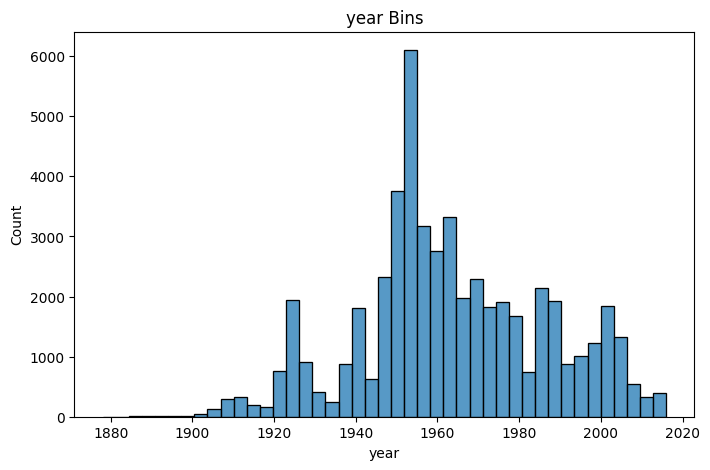

In [ ]:

# Area
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='year', bins=40)
plt.title('year Bins')
plt.xlabel('year')
plt.ylabel('Count')
plt.show()

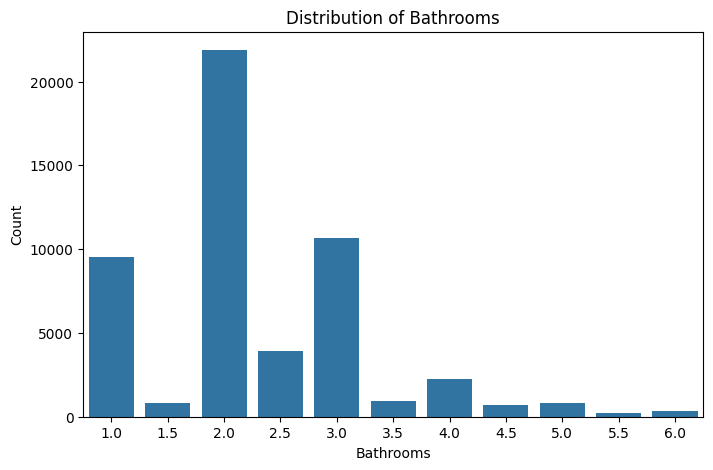

In [ ]:
# Plot a histogram for the 'bathrooms_bins' column
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bathrooms', color='#1f77b4') 
plt.title('Distribution of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
plt.xlim(-0.5,10.5)
plt.show()

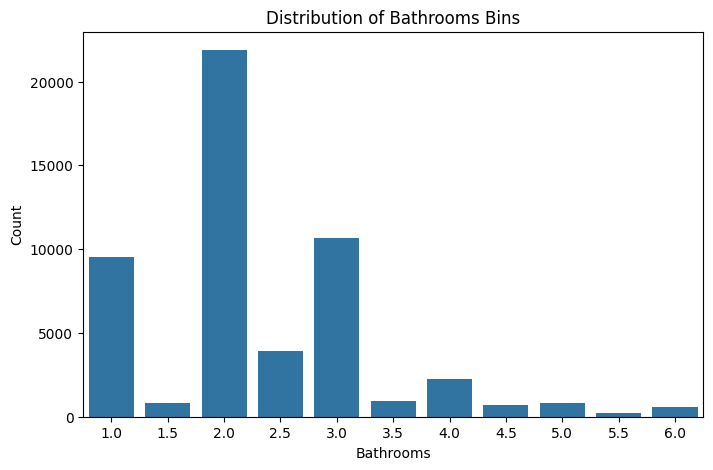

In [ ]:
# Plot a histogram for the 'bathrooms_bins' column
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bathrooms_bins', color='#1f77b4') 
plt.title('Distribution of Bathrooms Bins')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
plt.show()

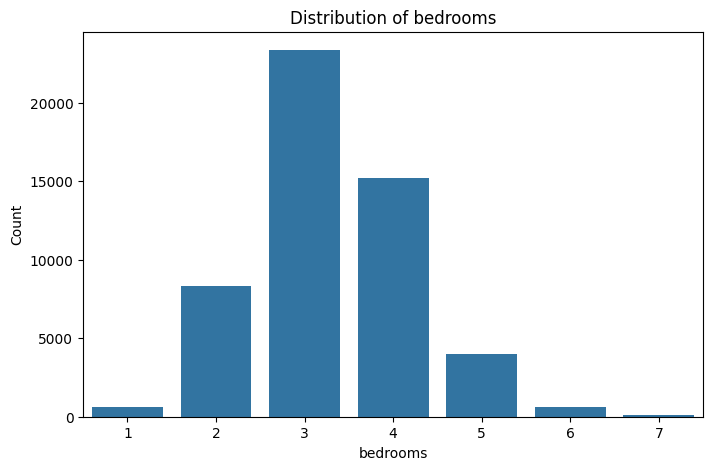

In [ ]:
# Plot a histogram for the 'bathrooms_bins' column
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bedrooms', color='#1f77b4') 
plt.title('Distribution of bedrooms')
plt.xlabel('bedrooms')
plt.ylabel('Count')
plt.xlim(-0.5,6.5)
plt.show()

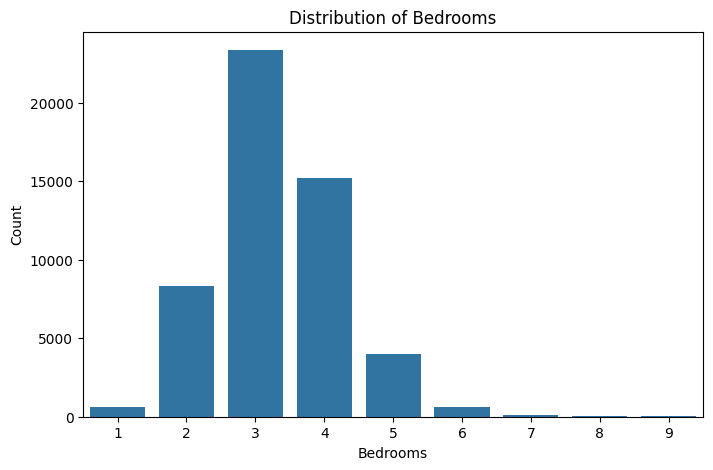

In [ ]:
# Plot a histogram for the 'bathrooms_bins' column
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bedrooms_bins', color='#1f77b4') 
plt.title('Distribution of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

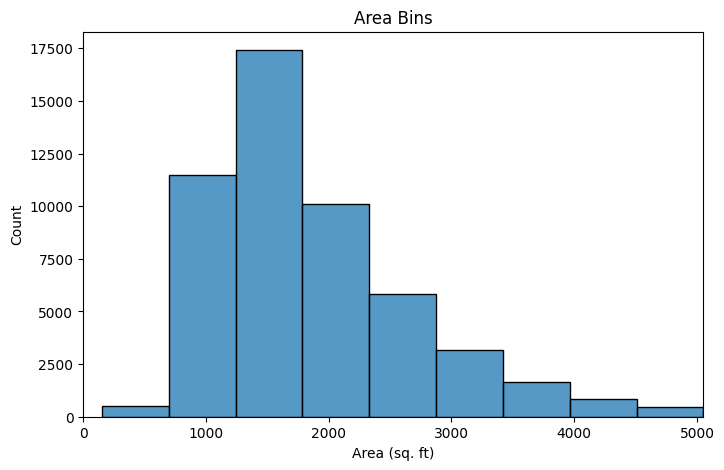

In [ ]:

# Area
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='area', bins=40)
plt.title('Area Bins')
plt.xlabel('Area (sq. ft)')
plt.ylabel('Count')
plt.xlim(-0.5,5050)
plt.show()

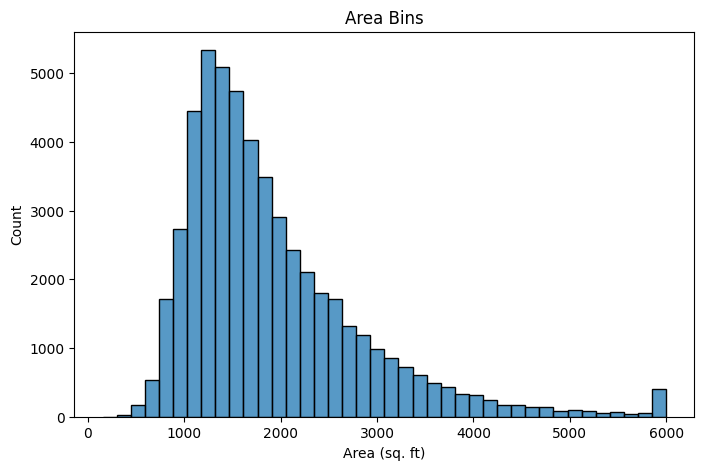

In [ ]:

# Area
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='area_bins', bins=40)
plt.title('Area Bins')
plt.xlabel('Area (sq. ft)')
plt.ylabel('Count')
plt.show()

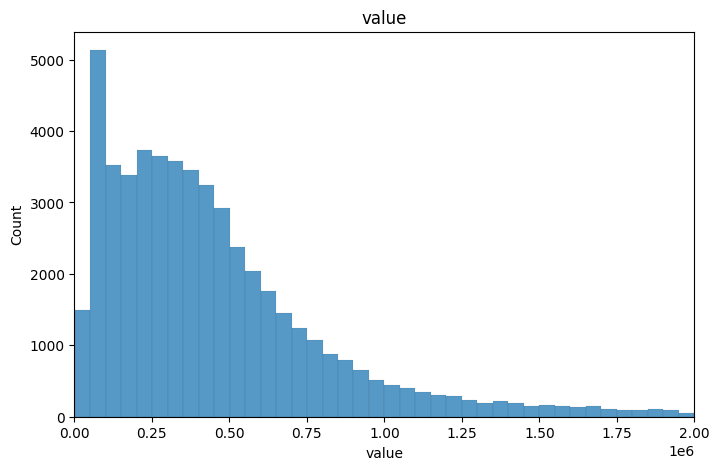

In [ ]:

# Area
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='value', bins=982)
plt.title('value')
plt.xlabel('value')
plt.ylabel('Count')
plt.xlim(-0.5,2000000)
plt.show()

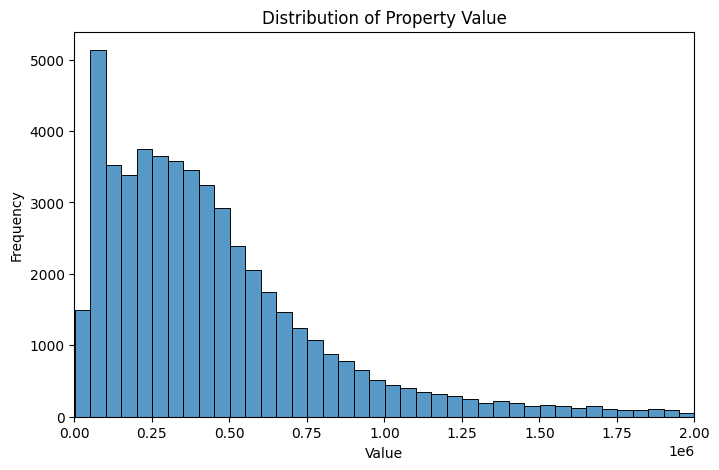

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='value_bins', bins=60)
plt.title('Distribution of Property Value')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(-0.5,2000000)
plt.show()

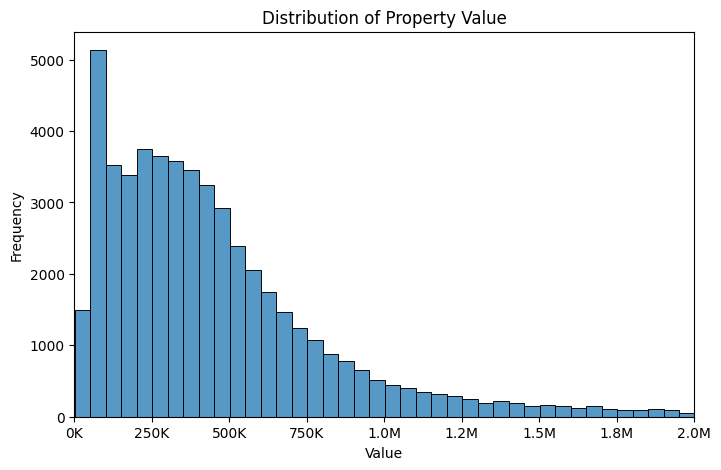

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

# Create a function to format x-axis labels
def millions_formatter(x, pos):
    """Format the x-axis labels in millions."""
    if x < 1e6:
        return f"{x / 1e3:.0f}K"
    else:
        return f"{x / 1e6:.1f}M"

# Create the histogram plot
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='value_bins', bins=60)
plt.title('Distribution of Property Value')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Set the x-axis limits
plt.xlim(-0.5, 2000000)

# Apply the custom formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.show()


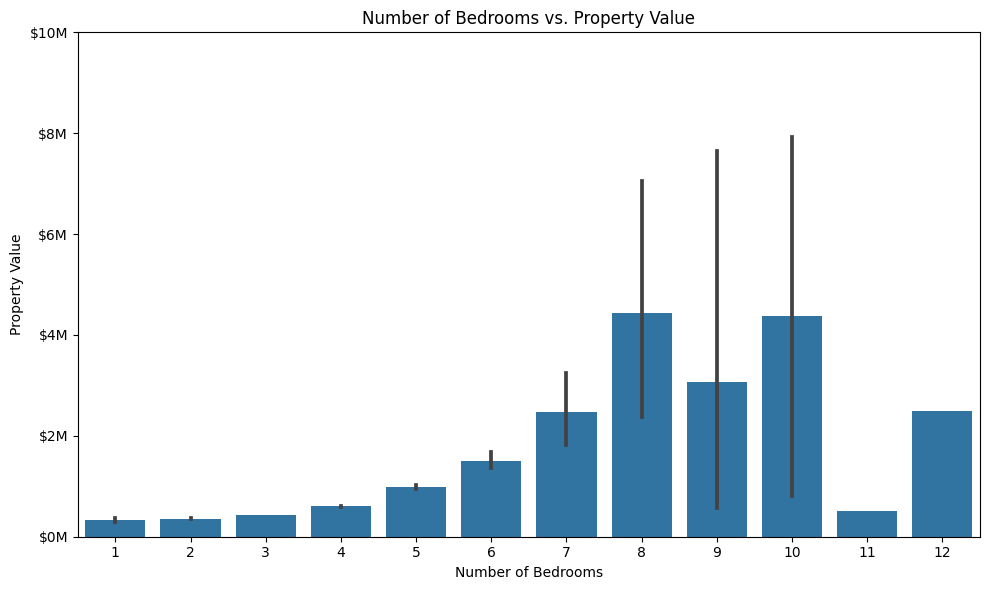

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(x='bedrooms', y='value', data=df, color='#1f77b4') 
plt.xlabel('Number of Bedrooms')
plt.ylabel('Property Value')
plt.title('Number of Bedrooms vs. Property Value')
plt.ylim(0, 10000000)  # ylim for property value
plt.xlim(-0.5, 11.5)  # xlim for bedrooms
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.0f}M'.format(x / 1e6)))  # Corrected the y-axis formatter

plt.tight_layout()
plt.show()

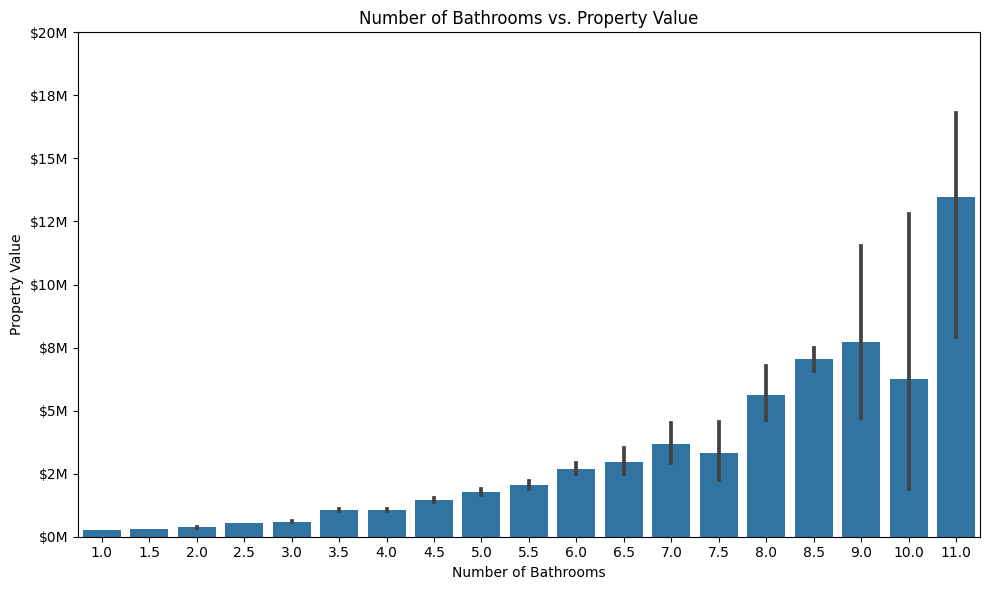

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(x='bathrooms', y='value', data=df, color='#1f77b4') 
plt.xlabel('Number of Bathrooms')
plt.ylabel('Property Value')
plt.title('Number of Bathrooms vs. Property Value')
plt.ylim(0, 20000000)  # ylim for property value
plt.xlim(-0.5, 18.5)  # xlim for bathrooms

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '${:.0f}M'.format(x / 1e6)))  # Corrected the y-axis formatter
plt.tight_layout()
plt.show()

In [ ]:
median_value = df['value'].median()
mean_value = df['value'].mean()

print(f'Median Value: {median_value}')
print(f'Mean Value: {mean_value}')

Median Value: 373508.0
Mean Value: 528146.4937411477


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
median_bedrooms = df['value'].groupby(df['bedrooms']).median()
mean_bedrooms = df['value'].groupby(df['bedrooms']).mean()

# Custom formatting function
def format_value(value):
    return f"${value:,.2f}"

# Format and print the median and mean values for bedrooms
print("Median Values for Bedrooms:")
print(median_bedrooms.apply(format_value))


Median Values for Bedrooms:
bedrooms
1        $214,770.00
2        $274,117.00
3        $339,530.00
4        $455,632.50
5        $682,572.50
6        $823,000.00
7        $950,510.00
8      $2,483,308.00
9        $650,249.50
10     $4,368,475.50
11       $510,400.00
12     $2,485,282.00
14    $49,061,236.00
Name: value, dtype: object


In [ ]:

print("\nMean Values for Bedrooms:")
print(mean_bedrooms.apply(format_value))



Mean Values for Bedrooms:
bedrooms
1        $335,338.55
2        $356,365.30
3        $426,851.48
4        $599,252.67
5        $987,980.97
6      $1,510,203.07
7      $2,468,488.56
8      $4,436,440.96
9      $3,060,478.88
10     $4,368,475.50
11       $510,400.00
12     $2,485,282.00
14    $49,061,236.00
Name: value, dtype: object


In [ ]:
median_bathrooms = df['value'].groupby(df['bathrooms']).median()
mean_bathrooms = df['value'].groupby(df['bathrooms']).mean()

# Format and print the median and mean values for bathrooms
print("Median Values for Bathrooms:")
print(median_bathrooms.apply(format_value))


Median Values for Bathrooms:
bathrooms
1.0        $234,051.00
1.5        $287,549.00
2.0        $310,723.50
2.5        $504,149.50
3.0        $499,624.00
3.5        $908,892.00
4.0        $845,000.00
4.5      $1,216,796.00
5.0      $1,311,061.00
5.5      $1,669,577.50
6.0      $2,161,114.00
6.5      $2,414,325.00
7.0      $2,681,208.00
7.5      $3,075,942.50
8.0      $4,984,456.00
8.5      $7,032,001.00
9.0      $5,990,204.00
10.0     $3,985,110.00
11.0    $15,623,925.00
13.0    $12,386,870.00
18.0    $49,061,236.00
Name: value, dtype: object


In [ ]:

print("\nMean Values for Bathrooms:")
print(mean_bathrooms.apply(format_value))



Mean Values for Bathrooms:
bathrooms
1.0        $278,805.51
1.5        $302,465.98
2.0        $369,922.08
2.5        $534,359.10
3.0        $594,956.14
3.5      $1,051,869.67
4.0      $1,071,889.89
4.5      $1,451,961.84
5.0      $1,773,604.41
5.5      $2,033,672.25
6.0      $2,695,018.22
6.5      $2,954,050.19
7.0      $3,660,246.42
7.5      $3,312,049.38
8.0      $5,634,891.57
8.5      $7,032,001.00
9.0      $7,729,813.31
10.0     $6,260,198.40
11.0    $13,454,449.00
13.0    $12,386,870.00
18.0    $49,061,236.00
Name: value, dtype: object
